## 6.2 高度なデモザイク処理

### この節について

この節では線形補間デモザイクよりも高度なデモザイクアルゴリズムをとりあげます。なお、この節の内容の大部分は"Frequency-Domain Methods for Demosaicking of Bayer-Sampled Color Images, Eric Dubois, IEEE Signal Processing Letters, Dec. 2005"に基づいています。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](http://bit.ly/raw_toc)から参照するか、以下のリンクを使ってアクセスしてください。

http://bit.ly/raw_chap_6_2

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction
from raw_process import demosaic, defect_correction, color_correction_matrix, lens_shading_correction
from raw_process import noise_filter, apply_matrix, edge_enhancement, tone_curve_correction

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
# もし日本語が文字化けしている場合以下の３行の行頭の#を削除して実行後、
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json
# その後Runtime->Restart Runtime選択してページ全体を再実行

### より高度なデモザイク処理

_この項は、画像処理の理論的背景に興味がない方は読み飛ばして構いません。_

線形補間デモザイクでは各色チャンネルをそれぞれ独立なものとして処理しました。ここでは、３色のBayer配列全体を一つの画像と見てみます。

前節でもとめた各色チャンネルの表現をもちいると、Bayer画像はこのように表記できます。

\begin{align}
f_{bayer} = & \frac{1}{2} f_G \left ( 1 - \left ( -1 \right ) ^ {x + y} \right ) + \\\
& \frac{1}{2} f_R \left ( 1 - \left ( -1 \right ) ^ {x} \right ) \left ( 1 - \left ( -1 \right ) ^ {y} \right ) + \\\
& \frac{1}{2} f_B \left ( 1 + \left ( -1 \right ) ^ {x} \right ) \left ( 1 + \left ( -1 \right ) ^ {y} \right )
\end{align}


ここで、
\begin{equation}
\left ( -1 \right ) ^ {x} = e ^ {i \pi x}\\
\left ( -1 \right ) ^ {y} = e ^ {i \pi y}\\
\left ( -1 \right ) ^ {x + y} = e ^ {i \pi \left( x + y \right)}\\
\end{equation}


を利用して、

\begin{align}
f_{bayer} = & \left ( \frac{1}{4} f_B + \frac{1}{2} f_G + \frac{1}{4} f_R \right ) + \\\
& \left ( \frac{1}{4} f_B - \frac{1}{2} f_G + \frac{1}{4} f_R \right ) \cdot e^{i \pi (x + y)} + \\\
& \left ( \frac{1}{4} f_B - \frac{1}{4} f_R \right ) \cdot (e^{i \pi x} + e^{i \pi y})
\end{align}


まとめると

\begin{align}
f_{bayer} & = f_{L} - f_{C1} e^{i \pi \left ( x + y \right ) } + f_{C2} \left ( e^{i \pi x} + e^{i \pi y} \right ) \\\
f_L & = \frac{1}{4} f_R + \frac{1}{2} f_G + \frac{1}{4} f_B \\\
f_{C1} & = \left ( \frac{1}{4} f_B - \frac{1}{2} f_G + \frac{1}{4} f_R \right ) \\\
f_{C2} & = \left ( \frac{1}{4} f_B - \frac{1}{4} f_R \right ) 
\end{align}

逆に、 $f_L$ 、 $f_{C1}$ 、 $f_{C2}$ から、 $f_R$ 、 $f_G$ 、 $f_B$ は、

$$
\begin{cases}
f_R = f_L + f_{C1} - 2f_{C2} \\\
f_G = f_L - f_{C1} \\\
f_B = f_L + f_{C1} - 2f_{C2} 
\end{cases}
$$

と、求められます。

では、 $f_L$ 、 $f_{C1}$ 、 $f_{C2}$ はどうやって計算すれば良いのか、というのが次の問題になります。

$f_L$ 、 $f_{C1}$ 、 $f_{C2}$ の定義をみると、 $f_R$ 、 $f_G$ 、 $f_B$ の線形結合なので元の画像が周波数制限されていて低い周波数の成分しかもっていないとすると、 $f_L$ 、 $f_{C1}$ 、 $f_{C2}$ も周波数制限されていると考えられます。

ここで前節のベイヤー画像の周波数特性の計算を思い出すと、 $f_{C1} e^{i \pi (x + y)}$ や $f_{C2} \left ( e^{i \pi x} + e^{i \pi y} \right )$ は $f_{C1}$ 、 $f_{C2}$ を周波数空間で $\pi$ だけシフトしたものです。
もとの$f_{Bayer}$はこれらを足し合わせたものなので、図に表すとこうなります。

![ベイヤー画像の周波数特性の分解](https://github.com/moizumi99/camera_raw_processing/raw/master/Figures/fig6_2_1.png)

ということは、 $_{Bayer}$ に帯域制限フィルターをかけて各成分をとりだして周波数をシフトすれば $f_L$ 、 $f_{C1}$ 、 $f_{C2}$ を得られるという事になります。

必要なフィルターは4つです。

- FC1 : 縦・横ハイパスフィルター。$ f_{C1} $を取り出すのに使います。

例：
\begin{equation}
F_{C1} = 
\left(\begin{array}{c} -1 \\\ 2 \\\ -3 \\\ 4 \\\ -3 \\\ 2 \\\ -1\end{array}\right)
\left(\begin{array}{c} -1, 2, -3, 4, -3, 2, -1\end{array}\right)
\end{equation}

- FC2V : 縦方向ハイパスフィルター、横方向ローパスフィルター。$ f_{C2}$の上下の成分を取り出すのに使います。

例：
\begin{equation}
F_{C2V} = 
\left(\begin{array}{c} -1 \\\ 2 \\\ -3 \\\ 4 \\\ -3 \\\ 2 \\\ -1\end{array}\right)
\left(\begin{array}{c} 1, 2, 3, 4, 3, 2, 1\end{array}\right)
\end{equation}

- FC2H: 縦方向ローパスフィルター、横方向ハイパスフィルター。$ f_{C2} $の左右の成分を取り出すのに使います。

例：
\begin{equation}
F_{C2H} = 
\left(\begin{array}{c} 1 \\\ 2 \\\ 3 \\\ 4 \\\ 3 \\\ 2 \\\ 1\end{array}\right)
\left(\begin{array}{c} -1, 2, -3, 4, -3, 2, -1\end{array}\right)
\end{equation}

- FL: (FC1 + FC2V + FC2H)を反転させたフィルター。$ f_{L} $の成分を取り出すのに使います。

例
\begin{equation}
F_L = 1 - F_{C1} - F_{C2V} - F_{C2H}
\end{equation}


これらを使えば、

\begin{align}
f_{C1} & = F_{C1}  \left ( f_{Bayer} \right ) e^{- i \pi \left ( x + y \right )} \\\
f_{C2V} & = F_{C2V} \left ( f_{Bayer} \right )  e^{-i \pi y} \\\
f_{C2H} & = F_{C2H} \left ( f_{Bayer} \right )  e^{-i \pi x} \\\
f_{C2} & = \left ( f_{C2V} + f_{C2H} \right ) / 2 \\\
f_L & = F_L \left ( f_{Bayer} \right ) 
\end{align}

となって $f_L$ 、 $f_{C1}$ 、 $f_{C2}$ の近似が計算でき、そこから $f_R$ 、 $f_G$ 、 $f_B$ が求められるはずです。
やってみましょう。

まずはホワイトバランスまでの処理を行います。

In [3]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(blc_raw, lsc)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_input = wb_raw

次に必要なFIRフィルターを準備しましょう。
まず、横方向のローパスフィルターです。

In [4]:
hlpf = np.array([[1, 2, 3, 4, 3, 2, 1]]) / 16

これを利用して、縦方向のローパスフィルターを作ります。numpyの転置機能を使います。

In [5]:
vlpf = np.transpose(hlpf)

同様に、横・縦方向のハイパスフィルターを作ります。

In [6]:
hhpf = np.array([[-1, 2, -3, 4, -3, 2, -1]]) / 16
vhpf = np.transpose(hhpf)

次に、等価フィルターを作ります。なにもしない（出力＝入力）フィルターです。

In [7]:
identity_filter = np.zeros((7, 7))
identity_filter[3, 3] = 1

これらの基本的なフィルターから、必要なフィルターを作っていきます。

FC1は、縦横ハイパスフィルターなので、こうなります。

In [8]:
FC1 = np.matmul(vhpf, hhpf)

FC2Vは縦ハイパス・横ローパス、FC2Hは縦ローパス・横ハイパスです。

In [9]:
FC2H = np.matmul(vlpf, hhpf)
FC2V = np.matmul(vhpf, hlpf)

FLは、等価フィルターからFC1, FC2V, FC2Hを取り除いたものです。

In [10]:
FL = identity_filter - FC1 - FC2V - FC2H

これで準備ができました。

ではまず、ハイパスフィルターを使って、C1成分を周波数空間の角からとりだしてみましょう。
SciPyの２次元コンボリューション機能を使います。

In [11]:
import scipy

# f_C1 at 4 corners
c1_mod = scipy.signal.convolve2d(dms_input, FC1, boundary='symm', mode='same')

同様に、C2V成分、C2H成分を取り出してみましょう。

In [12]:
# f_C1^1 at wy = 0, wx = +Pi/-Pi
c2h_mod = scipy.signal.convolve2d(dms_input, FC2H, boundary='symm', mode='same')
# f_C1^1 at wy = +Pi/-Pi, wx = 0
c2v_mod = scipy.signal.convolve2d(dms_input, FC2V, boundary='symm', mode='same')

最後にL成分をとりだします。

In [13]:
# f_L at center
f_L = scipy.signal.convolve2d(dms_input, FL, boundary='symm', mode='same')

今の所、C1成分、C2V・C2H成分は、周波数空間で $\pi$ だけずれています。色情報を復元するにはこれを復調してやる必要があります。

復調するためには$e^{-i \pi x}$や$e^{-i \pi y}$を掛け合わせなくてはならないのですが $x$ ,  $y$ はいずれも整数なので、結局 $-1$ と $＋１$ の繰り返しになります。
つまり$e^{-i \pi x}$をかけるのは奇数列の成分に-1をかける、$e^{-i \pi y}$をかけるのは奇数行の成分に-1をかけるのと同じです。

まずC1についてやってみましょう。必要な計算はこうなります。

In [14]:
# Move c1 to the center by shifting by Pi in both x and y direction
# f_c1 = c1 * (-1)^x * (-1)^y
f_c1 = c1_mod.copy()
f_c1[:, 1::2] *= -1
f_c1[1::2, :] *= -1

同様にC2V・C2Hでは必要な計算はこうなります。

In [15]:
# Move c2a to the center by shifting by Pi in x direction, same for c2b in y direction
c2v = c2v_mod.copy()
c2v[1::2, :] *= -1
c2h = c2h_mod.copy()
c2h[:, 1::2] *= -1
# f_c2 = (c2v_mod * x_mod + c2h_mod * y_mod) / 2
f_c2 = (c2v + c2h) / 2

これで$f_L$、$f_{C1}$、$f_{C2}$が求められました。

最後に、以下の式にしたがって$f_R$、$f_G$、$f_B$を計算します。

\begin{eqnarray}
f_R &=& f_L + f_{C1} + 2f_{C2} \\
f_G &=& f_L - f_{C1} \\
f_B &=& f_L + f_{C1} - 2f_{C2} 
\end{eqnarray}

やってみましょう。

In [16]:
# generate RGB channel using 
# [R, G, B] = [[1, 1, 2], [1, -1, 0], [1, 1, - 2]] x [L, C1, C2]
height, width = dms_input.shape
dms_img = np.zeros((height, width, 3))
dms_img[:,:,0] = f_L + f_c1 - 2 * f_c2
dms_img[:,:,1] = f_L - f_c1
dms_img[:,:,2] = f_L + f_c1 + 2 * f_c2

これでRGB画像が再現されたはずです！

解像感に影響のあるエッジ強調とノイズフィルター以外の処理を行い結果を確認してみましょう。

In [17]:
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)
ton_img = tone_curve_correction(gmm_img, (0, 0.28, 0.78, 1.0), (0, 0.22, 0.88, 1.0))

表示してみます。

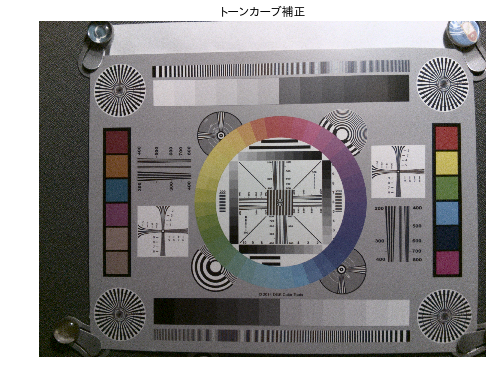

In [18]:
# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(ton_img)
plt.axis('off')
plt.title(u"トーンカーブ補正")
plt.show()

In [19]:
dms2_img = demosaic(wb_raw, raw.raw_colors)
ccm2_img = color_correction_matrix(dms2_img, color_matrix)
gmm2_img = gamma_correction(ccm2_img / white_level, 2.2)
ton2_img = tone_curve_correction(gmm2_img, (0, 0.28, 0.78, 1.0), (0, 0.22, 0.88, 1.0))

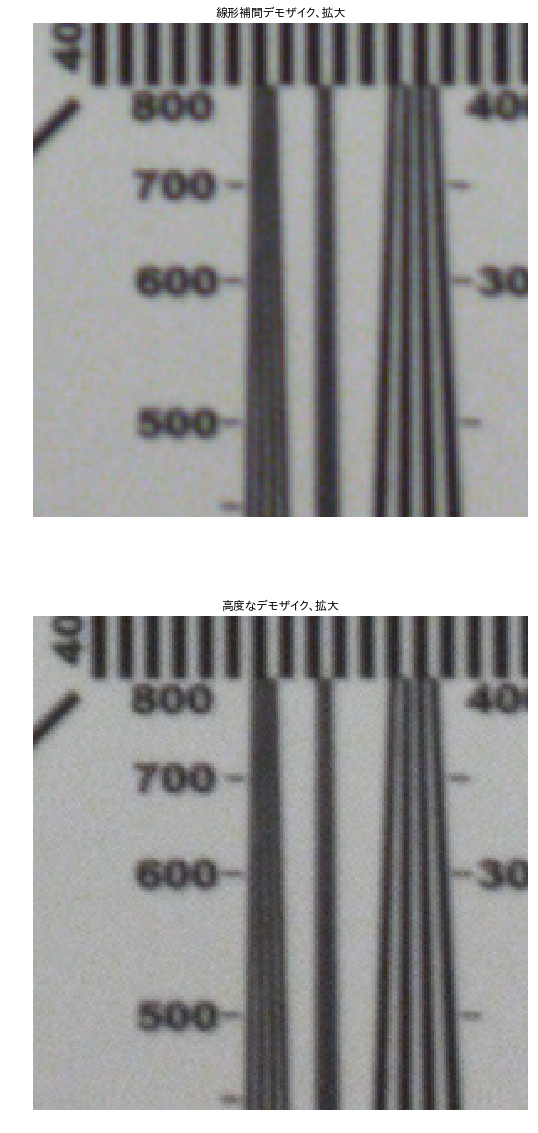

In [20]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
plt.imshow(ton2_img[1400:1600, 1650:1850, :])
plt.axis('off')
plt.title(u"線形補間デモザイク、拡大")
plt.subplot(2, 1, 2)
plt.imshow(ton_img[1400:1600, 1650:1850, :])
plt.axis('off')
plt.title(u"高度なデモザイク、拡大")
plt.show()

全体に画像のシャープさ感が上がっていること、また細かい模様やエッジ近辺などで偽色（本来ないはずの色）が減っている事がわかります。副作用としてノイズの量が増えていますが、このあたりはノイズフィルターで抑制するべきでしょう。

### モジュールへの追加

このデモザイクも関数としてモジュールに追加しておきましょう。

In [21]:
def advanced_demosaic(raw_array, bayer_pattern):
    """
    ベイヤー配列の周波数特性を利用したデモザイク処理。
    
    Parameters
    ----------
    raw_array: numpy 2d array
        入力RAW画像
    bayer_pattern: [2, 2] array
        2x2のBayer配列。0: R, 1:Gr(or G), 2:B, 3:Gb
        通常はRAWPYのrawpy.raw_patternの値を渡す。

    Returns
    -------
    dms_img: numpy array
        デモザイク後の画像
    """
    # 横方向ローパスフィルター
    hlpf = np.array([[1, 2, 3, 4, 3, 2, 1]]) / 16
    # 縦方向ローパスフィルター
    vlpf = np.transpose(hlpf)
    # 横方向ハイパスフィルター
    hhpf = np.array([[-1, 2, -3, 4, -3, 2, -1]]) / 16
    # 縦方向ハイパスフィルター
    vhpf = np.transpose(hhpf)
    # 等価フィルター
    identity_filter = np.zeros((7, 7))
    identity_filter[3, 3] = 1

    # 必用な周波数領域に対応するフィルター
    FC1 = np.matmul(vhpf, hhpf)
    FC2H = np.matmul(vlpf, hhpf)
    FC2V = np.matmul(vhpf, hlpf)
    FL = identity_filter - FC1 - FC2V - FC2H

    # f_C1 (四つ角の成分)をとりだす。
    c1_mod = scipy.signal.convolve2d(raw_array, FC1, boundary='symm', mode='same')
    # f_C2H (横軸方向の端)
    c2h_mod = scipy.signal.convolve2d(raw_array, FC2H, boundary='symm', mode='same')
    # f_C2V (縦軸方向の端)
    c2v_mod = scipy.signal.convolve2d(raw_array, FC2V, boundary='symm', mode='same')
    # f_L (中心部)
    f_L = scipy.signal.convolve2d(raw_array, FL, boundary='symm', mode='same')

    # C1を復調。周波数空間で(Pi, Pi)シフトして中心を(0, 0)に戻すのに相当。
    f_c1 = c1_mod.copy()
    f_c1[:, 1::2] *= -1
    f_c1[1::2, :] *= -1
    # 緑画像が左上にある場合、位相を１８０度ずらす。
    if bayer_pattern[0, 0] == 1 or bayer_pattern[0, 0] == 3:
        f_c1 *= -1
    # C2Hを復調。周波数空間で(Pi, 0)シフトして中心を(0, 0)に戻すのに相当。
    c2h = c2h_mod.copy()
    c2h[:, 1::2] *= -1
    # 青画像が左上か左下にある場合、位相を１８０度ずらす。
    if bayer_pattern[0, 0] == 2 or bayer_pattern[1, 0] == 2:
        c2h *= -1
    # C2Vを復調。周波数空間で(0, Pi)シフトして中心を(0, 0)に戻すのに相当。
    c2v = c2v_mod.copy()
    c2v[1::2, :] *= -1
    # 青画像が左上か右上にある場合、位相を１８０度ずらす。
    if bayer_pattern[0, 0] == 2 or bayer_pattern[0, 1] == 2:
        c2v *= -1
    # C2HとC2Vの平均からC2を求める。
    f_c2 = (c2v + c2h) / 2

    # R/G/B画像の合成。
    # [R, G, B] = [[1, 1, 2], [1, -1, 0], [1, 1, - 2]] x [L, C1, C2]
    height, width = raw_array.shape
    dms_img = np.zeros((height, width, 3))
    dms_img[:, :, 0] = f_L + f_c1 + 2 * f_c2
    dms_img[:, :, 1] = f_L - f_c1
    dms_img[:, :, 2] = f_L + f_c1 - 2 * f_c2

    return dms_img

このメソッドを使って全ての処理を行い、結果を確認してみましょう。

In [22]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(blc_raw, lsc)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = advanced_demosaic(wb_raw, raw.raw_pattern)
noise_model=(0.29300604909937544, 10.754229129481296)
nfl3_img = noise_filter(dms_img, noise_model)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(nfl3_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)
shp_img = edge_enhancement(gmm_img, 2, 0.25)
ton_img = tone_curve_correction(shp_img, (0, 0.28, 0.78, 1.0), (0, 0.22, 0.88, 1.0))

表示してみます。

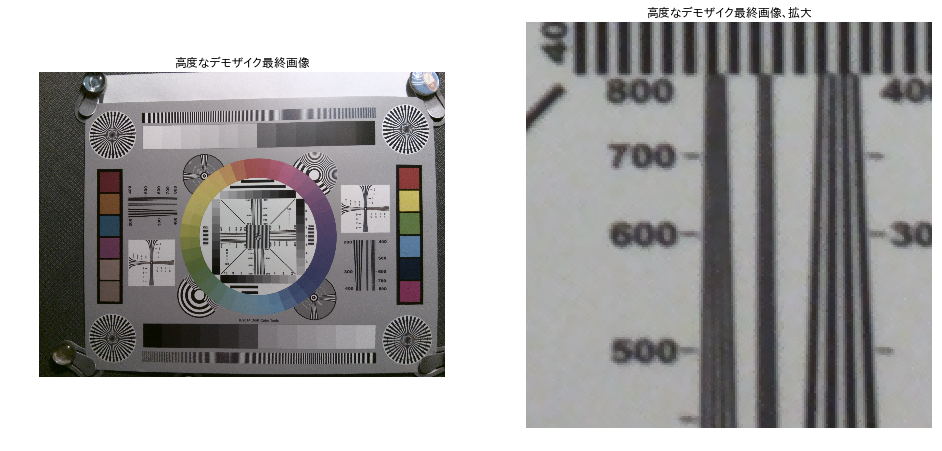

In [23]:
# 最終画像表示
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(ton_img)
plt.axis('off')
plt.title(u"高度なデモザイク最終画像")
plt.subplot(1, 2, 2)
plt.imshow(ton_img[1400:1600, 1650:1850, :])
plt.axis('off')
plt.title(u"高度なデモザイク最終画像、拡大")
plt.show()

うまくいったようです。

In [25]:
imageio.imsave("final_chart.jpg", ton_img)

### まとめ

今回は高度なデモザイク処理をとりあげました。

参照した論文[^1]ではさらに、一部のチャンネルを混ぜ合わせるときに各画素毎に重み計算を行うという適合処理的アルゴリズムを扱っています。今回は割愛しましたが、興味のある方は試されてはいかがでしょうか[^2]？

[^1]: Frequency-Domain Methods for Demosaicking of Bayer-Sampled Color Images, Eric Dubois, IEEE Signal Processing Letters, Dec. 2005

[^2]: 論文の著者グループが[WebにてMatlabのサンプルプログラムを配布しています](http://www.site.uottawa.ca/~edubois/SingleSensorImaging/Bayer_structure/)。また、今回のスクリプトを少し書き換えれば実現できることは確認済みです。

また、このアルゴリズムが発表されたのがすでに１３年前であり、これまでにさらにさまざまなアルゴリズムが提案されており、現在も進歩をつづけています[^3]。
たとえば、最近の流行はデモザイク処理にディープラーニングを使う手法です[^4]。

[^3]: たとえば高機能なRAW現像ソフトウェアRawTherapeeではさまざまなアルゴリズムを実装しているようです。https://rawpedia.rawtherapee.com/Demosaicing/jp

[^4]: https://arxiv.org/abs/1802.03769:title 

こういった事情を考慮にいれても、今回紹介した手法はシンプルな割には高画質の出力が得られる良いアルゴリズムだと思います。

次は全体の[まとめ](https://bit.ly/raw_chap_6_3)です。

